In [ ]:
# run this if working in colab

from google.colab import drive

drive.mount('/content/drive')

In [ ]:
# run this 2 cell if working in kaggle

!pip install gdown

In [ ]:
import gdown

# a file
url = " https://drive.google.com/file/d/1-09sgSnfWQk6C4-m5nxVD7dRrT2IjnZQ/view?usp=sharing"
output = "FruQ_MK2.zip"
gdown.download(url, output, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1-09sgSnfWQk6C4-m5nxVD7dRrT2IjnZQ
From (redirected): https://drive.google.com/uc?id=1-09sgSnfWQk6C4-m5nxVD7dRrT2IjnZQ&confirm=t&uuid=08fb90e2-fc19-474c-94d6-2c75da9d8913
To: /kaggle/working/FruQ_MK2.zip
100%|██████████| 4.58G/4.58G [00:33<00:00, 137MB/s] 


'FruQ_MK2.zip'

In [ ]:
# !unzip /kaggle/working/FruQ_MK2.zip
!unzip /content/drive/MyDrive/FruQ-DB/FruQ_MK2.zip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load library

In [4]:
import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

from PIL import Image

import seaborn as sns

from collections import Counter, defaultdict

import shutil

from sklearn.metrics import confusion_matrix, classification_report


Delete undesampled class

In [5]:
import shutil


# use this if working in kaggle
# shutil.rmtree("/kaggle/working/content/FruQ-multi-new/content/FruQ-multi/PepperQ")
# shutil.rmtree('/kaggle/working/content/FruQ-multi-new/content/FruQ-multi/WatermeloQ')

shutil.rmtree('/content/content/FruQ-multi-new/content/FruQ-multi/WatermeloQ')
shutil.rmtree('/content/content/FruQ-multi-new/content/FruQ-multi/PepperQ')

In [6]:
path = r'/content/content/FruQ-multi-new/content/FruQ-multi' # specify ur own path

In [7]:
original_dir = path



# Define the root directory for the new folder structure

new_dir = r'FruQ-new'

# Load data

restructure folder and limit the data to 300

In [8]:
import random



def restructure_dataset(original_dir, new_dir, max_images_per_class=300):

    """

    Restructure dataset from nested folders to flat fruit_quality folders

    with a limit on the number of images per class.



    Args:

        original_dir: Source directory with nested fruit folders

        new_dir: Destination directory for restructured dataset

        max_images_per_class: Maximum number of images to keep per class

    """

    # Create the new root directory if it doesn't exist

    os.makedirs(new_dir, exist_ok=True)



    # Iterate through the original directory and reorganize the folders

    for fruit in os.listdir(original_dir):

        fruit_path = os.path.join(original_dir, fruit)



        if not os.path.isdir(fruit_path):

            continue



        # Iterate through the "Fresh", "Mild", "Rotten" subdirectories

        for quality in os.listdir(fruit_path):

            quality_path = os.path.join(fruit_path, quality)



            if not os.path.isdir(quality_path):

                continue



            # Define the new folder name (e.g., "Banana_Fresh")

            new_folder_name = f"{fruit}_{quality}"

            new_folder_path = os.path.join(new_dir, new_folder_name)



            # Create the new folder if it doesn't exist

            os.makedirs(new_folder_path, exist_ok=True)



            # Get all image files

            image_files = [f for f in os.listdir(quality_path)

                           if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]



            # Randomly select up to max_images_per_class

            selected_images = random.sample(image_files, min(len(image_files), max_images_per_class))



            # Copy selected images (instead of moving)

            for image_file in selected_images:

                old_image_path = os.path.join(quality_path, image_file)

                new_image_path = os.path.join(new_folder_path, image_file)



                # Use copy2 to preserve metadata

                shutil.copy2(old_image_path, new_image_path)



            print(f"Copied {len(selected_images)} images from {quality_path} to {new_folder_path}")



    print("Folder restructuring complete!")

In [ ]:
restructure_dataset(path, new_dir)

# EDA

In [21]:
from typing import List, Dict, Set, Tuple

def analyze_multi_fruit_dataset(root_dir: str, exclude_fruits: List[str] = None) -> Dict:
    """
    Comprehensive analysis of multi-fruit image classification dataset.

    Args:
        root_dir: Root directory containing fruit_quality subdirectories
        exclude_fruits: List of fruit names to exclude from analysis

    Returns:
        dict: Statistics about the dataset
    """
    exclude_fruits = [fruit.lower() for fruit in (exclude_fruits or [])]

    stats = {
        'overall_distribution': defaultdict(int),
        'per_fruit_distribution': {},
        'image_sizes': defaultdict(list),
        'aspect_ratios': defaultdict(list),
        'file_formats': defaultdict(list),
        'color_stats': defaultdict(lambda: {
            'means': [],
            'stds': []
        }),
        'image_extensions': defaultdict(int),
        'available_fruits': set(),
        'available_classes': set()
    }

    # Discover available fruits and classes
    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)

        if not os.path.isdir(folder_path):
            continue

        # Split the folder name into fruit and quality
        parts = folder_name.rsplit('_', 1)
        if len(parts) < 2:
            continue

        fruit_type, quality = parts

        if fruit_type.lower() in exclude_fruits:
            print(f"Skipping {fruit_type} as requested...")
            continue

        # Add fruit type and quality to available sets
        stats['available_fruits'].add(fruit_type)
        stats['available_classes'].add(quality)

    # Convert sets to sorted lists for consistent ordering
    available_fruits = sorted(list(stats['available_fruits']))
    available_classes = sorted(list(stats['available_classes']))

    print(f"Detected fruits: {available_fruits}")
    print(f"Detected classes: {available_classes}")

    # Initialize per_fruit_distribution
    for fruit_type in available_fruits:
        stats['per_fruit_distribution'][fruit_type] = {
            class_name: 0 for class_name in available_classes
        }

    # Analyze images
    for folder_name in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, folder_name)

        if not os.path.isdir(folder_path):
            continue

        # Split the folder name into fruit and quality
        parts = folder_name.rsplit('_', 1)
        if len(parts) < 2:
            continue

        fruit_type, quality = parts

        if fruit_type.lower() in exclude_fruits:
            continue

        # Get all image files in the directory
        image_files = [f for f in os.listdir(folder_path)
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        n_images = len(image_files)

        # Update distribution counts
        stats['per_fruit_distribution'][fruit_type][quality] = n_images
        stats['overall_distribution'][quality] += n_images

        # Analyze individual images
        for img_file in image_files:
            img_path = os.path.join(folder_path, img_file)
            _, file_extension = os.path.splitext(img_file)

            # Count image extensions
            stats['image_extensions'][file_extension.lower()] += 1

            try:
                with Image.open(img_path) as img:
                    # Image dimensions
                    width, height = img.size
                    stats['image_sizes'][fruit_type].append((width, height))
                    stats['aspect_ratios'][fruit_type].append(width/height)
                    stats['file_formats'][fruit_type].append(img.format)

                    # Color statistics
                    img_array = np.array(img)
                    if len(img_array.shape) == 3:  # Check if image is RGB
                        means = img_array.mean(axis=(0,1))
                        stds = img_array.std(axis=(0,1))
                        stats['color_stats'][fruit_type]['means'].append(means)
                        stats['color_stats'][fruit_type]['stds'].append(stds)

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")

    return stats

In [22]:
def print_dataset_summary(stats):
    """
    Print summary statistics about the multi-fruit dataset
    Args:
        stats: Dictionary containing dataset statistics
    """
    print("Dataset Summary:")
    print("=" * 50)

    print("\nOverall Distribution:")
    total_images = sum(stats['overall_distribution'].values())
    for class_name, count in stats['overall_distribution'].items():
        percentage = (count / total_images) * 100
        print(f"{class_name}: {count} images ({percentage:.1f}%)")

    print("\nPer-fruit Distribution:")
    print("=" * 50)
    for fruit_type, distribution in stats['per_fruit_distribution'].items():
        print(f"\n{fruit_type}:")
        fruit_total = sum(distribution.values())
        for class_name, count in distribution.items():
            percentage = (count / fruit_total) * 100 if fruit_total > 0 else 0
            print(f"  {class_name}: {count} images ({percentage:.1f}%)")

        # Size statistics for this fruit
        sizes = np.array(stats['image_sizes'][fruit_type])
        if len(sizes) > 0:
            print(f"\n  Image Dimensions:")
            print(f"  Min size: {sizes.min(axis=0)}")
            print(f"  Max size: {sizes.max(axis=0)}")
            print(f"  Mean size: {sizes.mean(axis=0).astype(int)}")

            ratios = np.array(stats['aspect_ratios'][fruit_type])
            print(f"\n  Aspect Ratios:")
            print(f"  Min: {ratios.min():.2f}")
            print(f"  Max: {ratios.max():.2f}")
            print(f"  Mean: {ratios.mean():.2f}")

        # Image format statistics for this fruit
        formats = stats['file_formats'][fruit_type]
        format_counts = defaultdict(int)
        for fmt in formats:
            format_counts[fmt] += 1

        if format_counts:
            print(f"\n  Image Formats:")
            for fmt, count in format_counts.items():
                format_percentage = (count / len(formats)) * 100 if formats else 0
                print(f"  {fmt}: {count} images ({format_percentage:.1f}%)")

    print("=" * 50)

In [23]:
def print_dataset_summary(stats):
    """
    Print summary statistics about the multi-fruit dataset
    Args:
        stats: Dictionary containing dataset statistics
    """
    print("Dataset Summary:")
    print("=" * 50)

    print("\nOverall Distribution:")
    total_images = sum(stats['overall_distribution'].values())
    for class_name, count in stats['overall_distribution'].items():
        percentage = (count / total_images) * 100
        print(f"{class_name}: {count} images ({percentage:.1f}%)")

    print("\nPer-fruit Distribution:")
    print("=" * 50)
    for fruit_type, distribution in stats['per_fruit_distribution'].items():
        print(f"\n{fruit_type}:")
        fruit_total = sum(distribution.values())
        for class_name, count in distribution.items():
            percentage = (count / fruit_total) * 100 if fruit_total > 0 else 0
            print(f"  {class_name}: {count} images ({percentage:.1f}%)")

        # Size statistics for this fruit
        sizes = np.array(stats['image_sizes'][fruit_type])
        if len(sizes) > 0:
            print(f"\n  Image Dimensions:")
            print(f"  Min size: {sizes.min(axis=0)}")
            print(f"  Max size: {sizes.max(axis=0)}")
            print(f"  Mean size: {sizes.mean(axis=0).astype(int)}")

            ratios = np.array(stats['aspect_ratios'][fruit_type])
            print(f"\n  Aspect Ratios:")
            print(f"  Min: {ratios.min():.2f}")
            print(f"  Max: {ratios.max():.2f}")
            print(f"  Mean: {ratios.mean():.2f}")

        # Image format statistics for this fruit
        formats = stats['file_formats'][fruit_type]
        format_counts = defaultdict(int)
        for fmt in formats:
            format_counts[fmt] += 1

        if format_counts:
            print(f"\n  Image Formats:")
            for fmt, count in format_counts.items():
                format_percentage = (count / len(formats)) * 100 if formats else 0
                print(f"  {fmt}: {count} images ({format_percentage:.1f}%)")

    print("=" * 50)

In [24]:
def plot_classes_side_by_side(stats):
    """
    Create a single plot with side-by-side bars for each fruit
    Args:
        stats: Dictionary containing dataset statistics
    """
    fruits = list(stats['per_fruit_distribution'].keys())
    classes = list(stats['available_classes'])

    # Set width of each bar and positions of the bars
    bar_width = 0.25
    r = np.arange(len(fruits))

    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot bars for each class
    bars = []
    for idx, class_name in enumerate(classes):
        class_counts = [stats['per_fruit_distribution'][fruit][class_name]
                       for fruit in fruits]
        position = [x + bar_width*idx for x in r]
        bar = plt.bar(position, class_counts, bar_width,
                     label=class_name)
        bars.append(bar)

        # Add value labels on top of each bar
        for b in bar:
            height = b.get_height()
            plt.text(b.get_x() + b.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom')

    # Customize the plot
    plt.xlabel('Fruits')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Classes Across Fruits')
    plt.xticks([r + bar_width for r in range(len(fruits))], fruits, rotation=45)
    plt.legend()

    plt.tight_layout()
    return plt.gcf()


In [25]:
stats = analyze_multi_fruit_dataset(new_dir)

Detected fruits: ['AvocadoQ', 'BananaDB', 'CucumberQ', 'GrapefruitQ', 'KakiQ', 'PapayaQ', 'PeachQ', 'tomatoQ']
Detected classes: ['Fresh', 'Mild', 'Rotten']


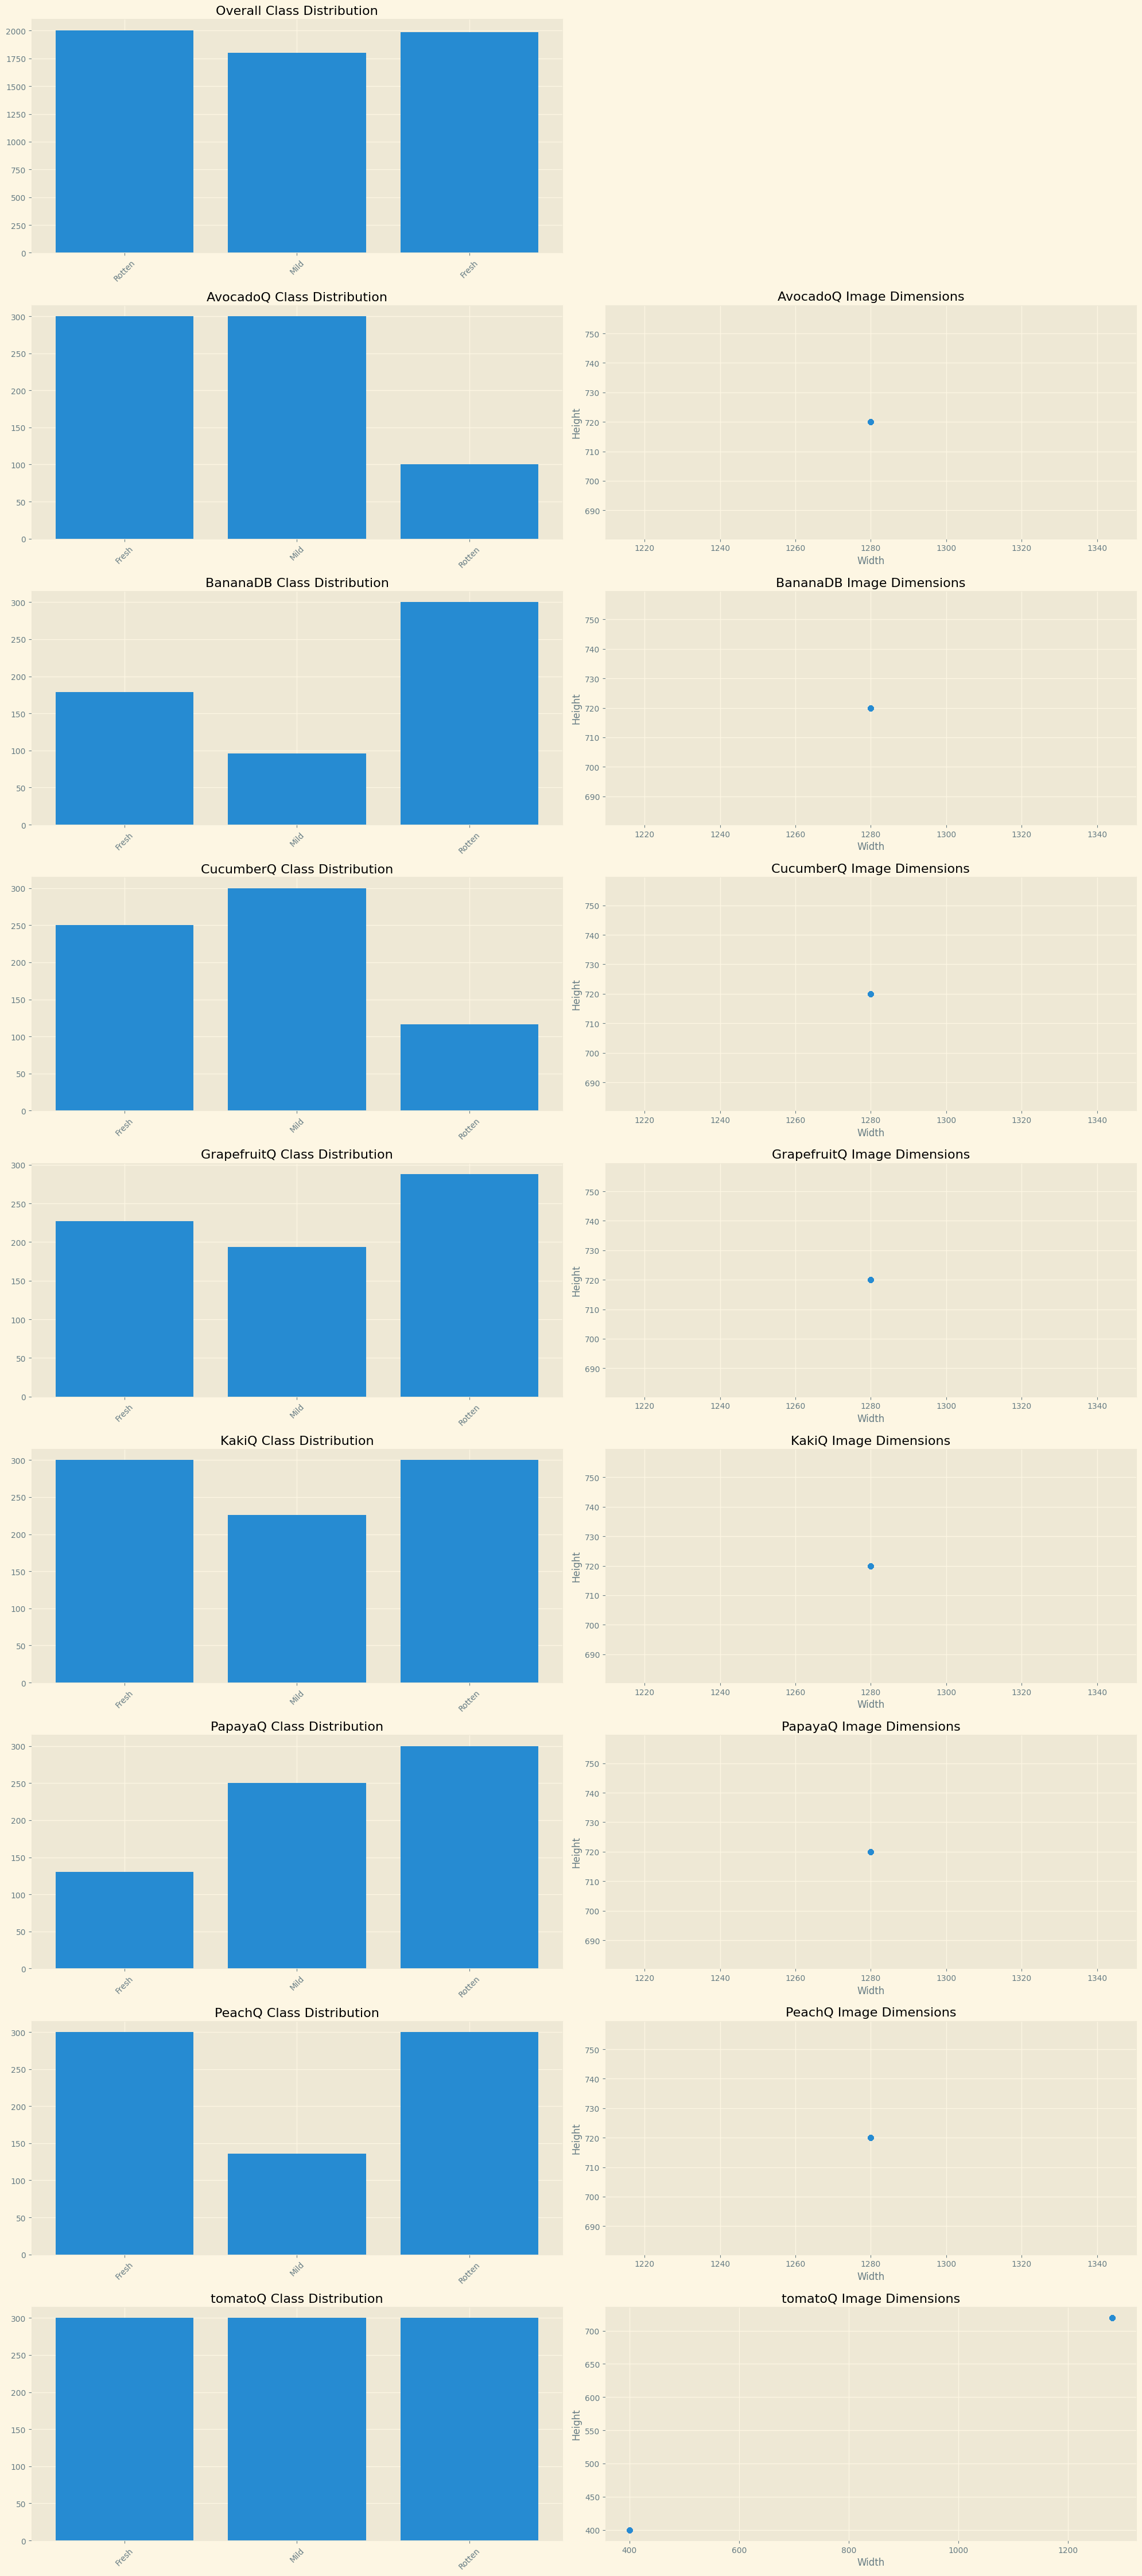

In [26]:
plot_dataset_analysis(stats)

In [27]:
print_dataset_summary(stats)

Dataset Summary:

Overall Distribution:
Rotten: 2004 images (34.6%)
Mild: 1802 images (31.1%)
Fresh: 1986 images (34.3%)

Per-fruit Distribution:

AvocadoQ:
  Fresh: 300 images (42.9%)
  Mild: 300 images (42.9%)
  Rotten: 100 images (14.3%)

  Image Dimensions:
  Min size: [1280  720]
  Max size: [1280  720]
  Mean size: [1280  720]

  Aspect Ratios:
  Min: 1.78
  Max: 1.78
  Mean: 1.78

  Image Formats:
  PNG: 700 images (100.0%)

BananaDB:
  Fresh: 179 images (31.1%)
  Mild: 96 images (16.7%)
  Rotten: 300 images (52.2%)

  Image Dimensions:
  Min size: [1280  720]
  Max size: [1280  720]
  Mean size: [1280  720]

  Aspect Ratios:
  Min: 1.78
  Max: 1.78
  Mean: 1.78

  Image Formats:
  PNG: 575 images (100.0%)

CucumberQ:
  Fresh: 250 images (37.5%)
  Mild: 300 images (45.0%)
  Rotten: 116 images (17.4%)

  Image Dimensions:
  Min size: [1280  720]
  Max size: [1280  720]
  Mean size: [1280  720]

  Aspect Ratios:
  Min: 1.78
  Max: 1.78
  Mean: 1.78

  Image Formats:
  PNG: 666 ima

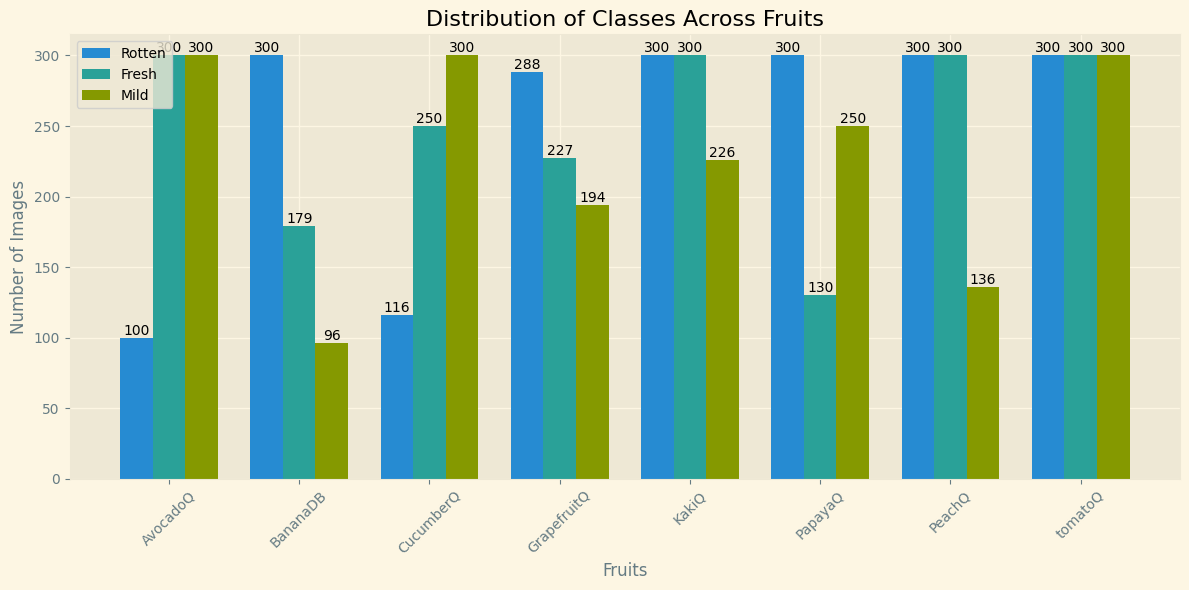

In [28]:
# Create side-by-side comparison
side_by_side_fig = plot_classes_side_by_side(stats)
plt.figure(side_by_side_fig.number)
plt.show()


# Create dataset

In [ ]:
  from tensorflow.keras import layers

  from tensorflow.keras.applications.resnet50 import preprocess_input



  SEED = 123

  IMG_SIZE = 224

  def create_dataset(data_dir, img_size=(IMG_SIZE, IMG_SIZE), batch_size=8, buffer_size=1000):



    # Define data augmentation layer

    data_augmentation = tf.keras.Sequential([

        layers.RandomFlip("horizontal"),

        layers.RandomRotation(0.2),

        layers.RandomZoom(0.2),

        layers.RandomBrightness(0.2),

        layers.RandomTranslation(0.2, 0.2)

    ])





    # Create the dataset

    train_data = tf.keras.utils.image_dataset_from_directory(

        data_dir,

        labels='inferred',

        label_mode='categorical',

        class_names=None,

        color_mode='rgb',

        batch_size=batch_size,

        image_size=img_size,

        shuffle=True,

        seed=SEED,

        validation_split=0.2,

        subset='training',

        interpolation='bilinear'

    )

    class_names = train_data.class_names



    # Combine data augmentation and preprocessing

    augmented_train_dataset = train_data.map(

        lambda x, y: (preprocess_input(data_augmentation(x, training=True)), y)

    )



    # Configure the dataset for performance

    train_data_optimized = augmented_train_dataset.cache()\
      .shuffle(buffer_size)\
      .prefetch(buffer_size=tf.data.AUTOTUNE)



    val_data = tf.keras.utils.image_dataset_from_directory(

        data_dir,

        labels='inferred',

        label_mode='categorical',

        class_names=class_names,

        color_mode='rgb',

        batch_size=batch_size,

        image_size=img_size,

        shuffle=True,

        seed=SEED,

        validation_split=0.2,

        subset='validation',

        interpolation='bilinear'

    )



    # Apply preprocessing to validation data as well

    val_data = val_data.map(lambda x, y: (preprocess_input(x), y))



    return train_data, train_data_optimized, val_data, class_names, augmented_train_dataset

In [ ]:
# Create train and validation datasets

train_data, train_data_optimized, val_data, class_names, augmented_train_dataset = create_dataset(new_dir)

print(f"Images of train dataset have shape: {train_data.element_spec[0].shape}")

print(f"Labels of train dataset have shape: {train_data_optimized.element_spec[1].shape}")

print(f"Images of validation dataset have shape: {val_data.element_spec[0].shape}")

print(f"Labels of validation dataset have shape: {val_data.element_spec[1].shape}")

print(f"Class names are: {class_names}")

Found 5792 files belonging to 24 classes.
Using 4634 files for training.
Found 5792 files belonging to 24 classes.
Using 1158 files for validation.
Images of train dataset have shape: (None, 224, 224, 3)
Labels of train dataset have shape: (None, 24)
Images of validation dataset have shape: (None, 224, 224, 3)
Labels of validation dataset have shape: (None, 24)
Class names are: ['AvocadoQ_Fresh', 'AvocadoQ_Mild', 'AvocadoQ_Rotten', 'BananaDB_Fresh', 'BananaDB_Mild', 'BananaDB_Rotten', 'CucumberQ_Fresh', 'CucumberQ_Mild', 'CucumberQ_Rotten', 'GrapefruitQ_Fresh', 'GrapefruitQ_Mild', 'GrapefruitQ_Rotten', 'KakiQ_Fresh', 'KakiQ_Mild', 'KakiQ_Rotten', 'PapayaQ_Fresh', 'PapayaQ_Mild', 'PapayaQ_Rotten', 'PeachQ_Fresh', 'PeachQ_Mild', 'PeachQ_Rotten', 'tomatoQ_Fresh', 'tomatoQ_Mild', 'tomatoQ_Rotten']


In [ ]:
from sklearn.utils.class_weight import compute_class_weight



y_train = np.concatenate([y.numpy() for _, y in train_data])

# Convert one-hot encoded labels back to class indices

y_train_classes = np.argmax(y_train, axis=1)



# Compute class weights

classes = np.unique(y_train_classes)

class_weights = compute_class_weight('balanced', classes=classes, y=y_train_classes)



# Convert to dictionary for TensorFlow

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}



print(class_weight_dict)


{0: 0.7913251366120219, 1: 0.7945816186556928, 2: 2.326305220883534, 3: 1.3408564814814814, 4: 2.4440928270042193, 5: 0.7512970168612192, 6: 0.9654166666666667, 7: 0.8112745098039216, 8: 2.298611111111111, 9: 1.0667587476979743, 10: 1.253787878787879, 11: 0.8939043209876543, 12: 0.7785618279569892, 13: 1.0667587476979743, 14: 0.8181497175141242, 15: 1.8929738562091503, 16: 0.9464869281045751, 17: 0.8468567251461988, 18: 0.7880952380952381, 19: 1.7714067278287462, 20: 0.7754350736278447, 21: 0.7880952380952381, 22: 0.8286838340486409, 23: 0.8358585858585859}


# Model Creation

In [ ]:
from tensorflow.keras.models import Model



def create_model(num_classes):

    base_model = tf.keras.applications.ResNet50(

        weights='imagenet',

        include_top=False,

        input_shape=(IMG_SIZE, IMG_SIZE, 3)

    )



    # Freeze base model

    base_model.trainable = False



    inputs = base_model.input

    x = base_model(inputs, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)





    # Create model

    model = Model(inputs=inputs, outputs=outputs, name='fruit_classifier')



    return model


# Model Compilation

In [ ]:
def compile_model(model):

    model.compile(

        optimizer = tf.keras.optimizers.Adam(

        learning_rate=0.001

    ),

        loss='categorical_crossentropy',

        metrics=['accuracy']

    )




# Callbacks


In [ ]:
import datetime



# Create log directory with timestamp

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


In [ ]:
def create_callbacks():

    return [

        tf.keras.callbacks.EarlyStopping(

            monitor='val_loss',

            patience=10,

            restore_best_weights=True,

            min_delta=0.001

        ),

        tf.keras.callbacks.ModelCheckpoint(

            filepath=os.path.join(log_dir, 'model-{epoch:02d}-{val_accuracy:.2f}.keras'),

            monitor='val_accuracy',

            save_best_only=True,

            mode='max',

        ),

        tf.keras.callbacks.ReduceLROnPlateau(

            monitor='val_loss',

            factor=0.2,

            patience=5,

            min_lr=1e-6

        )

    ]




# Training History Plotting


In [ ]:
def plot_training_history(history, title):

    plt.figure(figsize=(12, 4))



    # Plot accuracy

    plt.subplot(1, 2, 1)

    plt.plot(history.history['accuracy'])

    plt.plot(history.history['val_accuracy'])

    plt.title(f'{title} - Accuracy')

    plt.ylabel('Accuracy')

    plt.xlabel('Epoch')

    plt.legend(['Train', 'Validation'])



    # Plot loss

    plt.subplot(1, 2, 2)

    plt.plot(history.history['loss'])

    plt.plot(history.history['val_loss'])

    plt.title(f'{title} - Loss')

    plt.ylabel('Loss')

    plt.xlabel('Epoch')

    plt.legend(['Train', 'Validation'])



    plt.tight_layout()

    plt.show()




# Metric


In [ ]:
def metric(model, dataset, class_names, title="Confusion Matrix"):

    # Get true labels and predictions

    y_true = []

    y_pred = []



    for images, labels in dataset:

        # Append true labels

        y_true.extend(np.argmax(labels.numpy(), axis=1))



        # Predict on images

        predictions = model.predict(images)

        y_pred.extend(np.argmax(predictions, axis=1))



    y_true = np.array(y_true)

    y_pred = np.array(y_pred)



    # Create confusion matrix

    cm = confusion_matrix(y_true, y_pred)



    # Plot confusion matrix

    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)

    sns.heatmap(

        cm,

        annot=True,

        fmt='d',

        cmap='Blues',

        xticklabels=class_names,

        yticklabels=class_names

    )

    plt.title(f"{title}\nConfusion Matrix")

    plt.ylabel('True Label')

    plt.xlabel('Predicted Label')



    # Generate classification report

    report = classification_report(

        y_true,

        y_pred,

        target_names=class_names,

        output_dict=True

    )



    # Create metrics visualization

    plt.subplot(1, 2, 2)

    metrics_data = {

        'Precision': [],

        'Recall': [],

        'F1-Score': []

    }



    # Get metrics for each class

    for class_name in class_names:

        metrics_data['Precision'].append(report[class_name]['precision'])

        metrics_data['Recall'].append(report[class_name]['recall'])

        metrics_data['F1-Score'].append(report[class_name]['f1-score'])



    # Add macro average

    metrics_data['Precision'].append(report['macro avg']['precision'])

    metrics_data['Recall'].append(report['macro avg']['recall'])

    metrics_data['F1-Score'].append(report['macro avg']['f1-score'])



    # Create labels for all classes plus macro average

    all_labels = class_names + ['Macro Avg']

    x = np.arange(len(all_labels))

    width = 0.25



    # Plot bars for each metric

    plt.bar(x - width, metrics_data['Precision'], width, label='Precision')

    plt.bar(x, metrics_data['Recall'], width, label='Recall')

    plt.bar(x + width, metrics_data['F1-Score'], width, label='F1-Score')



    plt.xlabel('Classes')

    plt.ylabel('Score')

    plt.title(f'{title}\nPrecision, Recall, and F1-Score')

    plt.xticks(x, all_labels, rotation=45)

    plt.legend()

    plt.tight_layout()

    plt.show()



    # Print detailed classification report

    print("\nDetailed Classification Report:")

    print("\nPer-Class Metrics:")

    print("-" * 60)

    for class_name in class_names:

        print(f"\n{class_name}:")

        print(f"Precision: {report[class_name]['precision']:.3f}")

        print(f"Recall: {report[class_name]['recall']:.3f}")

        print(f"F1-Score: {report[class_name]['f1-score']:.3f}")



    print("\nMacro-Averaged Metrics:")

    print("-" * 60)

    print(f"Macro Precision: {report['macro avg']['precision']:.3f}")

    print(f"Macro Recall: {report['macro avg']['recall']:.3f}")

    print(f"Macro F1-Score: {report['macro avg']['f1-score']:.3f}")



    # Print support (number of samples per class)

    print("\nClass Support (Number of Samples):")

    print("-" * 60)

    for class_name in class_names:

        print(f"{class_name}: {report[class_name]['support']}")

In [ ]:
def evaluate_models(model, val):

  classes = class_names

  metric(

      model,

      val,

      classes,

      f"{type} Classification Confusion Matrix"

  )

# Model Training Function

In [ ]:
fruit_model = create_model(

        num_classes=len(class_names)

    )



compile_model(fruit_model)

In [ ]:
fruit_model.summary()

Model: "fruit_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │           3,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,853,080 (90.99 MB)

 Trainable params: 265,368 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = fruit_model.fit(train_data_optimized,

                    epochs=50,

                    validation_data=val_data,

                    callbacks=create_callbacks(),

                    class_weight=class_weight_dict

                    )

Epoch 1/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 245s 118ms/step - accuracy: 0.7193 - loss: 2.5682 - val_accuracy: 0.8048 - val_loss: 1.0825 - learning_rate: 0.0010
Epoch 2/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 48s 82ms/step - accuracy: 0.8963 - loss: 0.7771 - val_accuracy: 0.9413 - val_loss: 0.6260 - learning_rate: 0.0010
Epoch 3/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 93s 101ms/step - accuracy: 0.9077 - loss: 0.6505 - val_accuracy: 0.9085 - val_loss: 0.4934 - learning_rate: 0.0010
Epoch 4/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 68s 77ms/step - accuracy: 0.9040 - loss: 0.5264 - val_accuracy: 0.9326 - val_loss: 0.4422 - learning_rate: 0.0010
Epoch 5/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 97s 102ms/step - accuracy: 0.9106 - loss: 0.5256 - val_accuracy: 0.9465 - val_loss: 0.4394 - learning_rate: 0.0010
Epoch 6/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 45s 78ms/step - accuracy: 0.9090 - loss: 0.5217 - val_accuracy: 0.9663 - val_loss: 0.3651 - learning_rate: 0.0010
Epoch 7/50
580/580 ━━━━━━━━━━━━━━━━━━━━ 95s 101ms/step - accuracy: 0.914

save the model

In [ ]:
fruit_model.save('fruit_classifier_final.keras')

In [ ]:
fruit_model.save('fruit_classifier_final.h5')

plot the training history

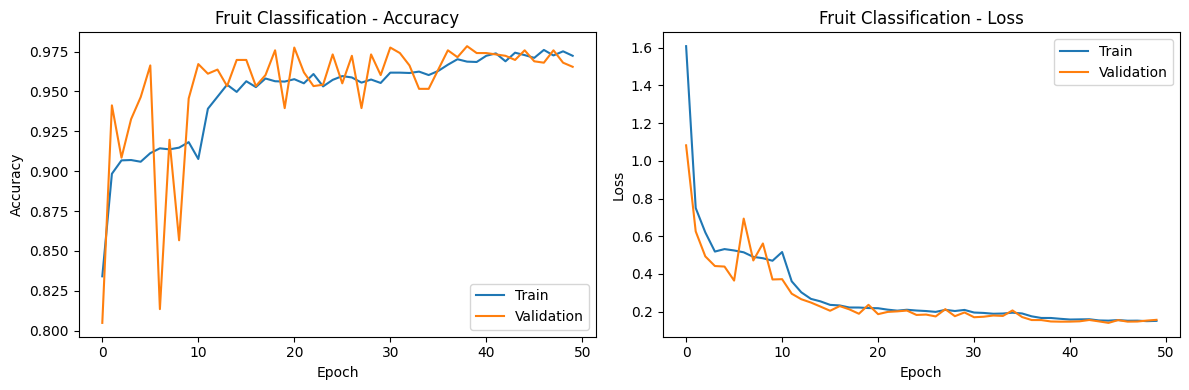

In [ ]:
plot_training_history(history, "Fruit Classification")

evaluate the model by calculating several matrix and create the confusion matrix graph

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step

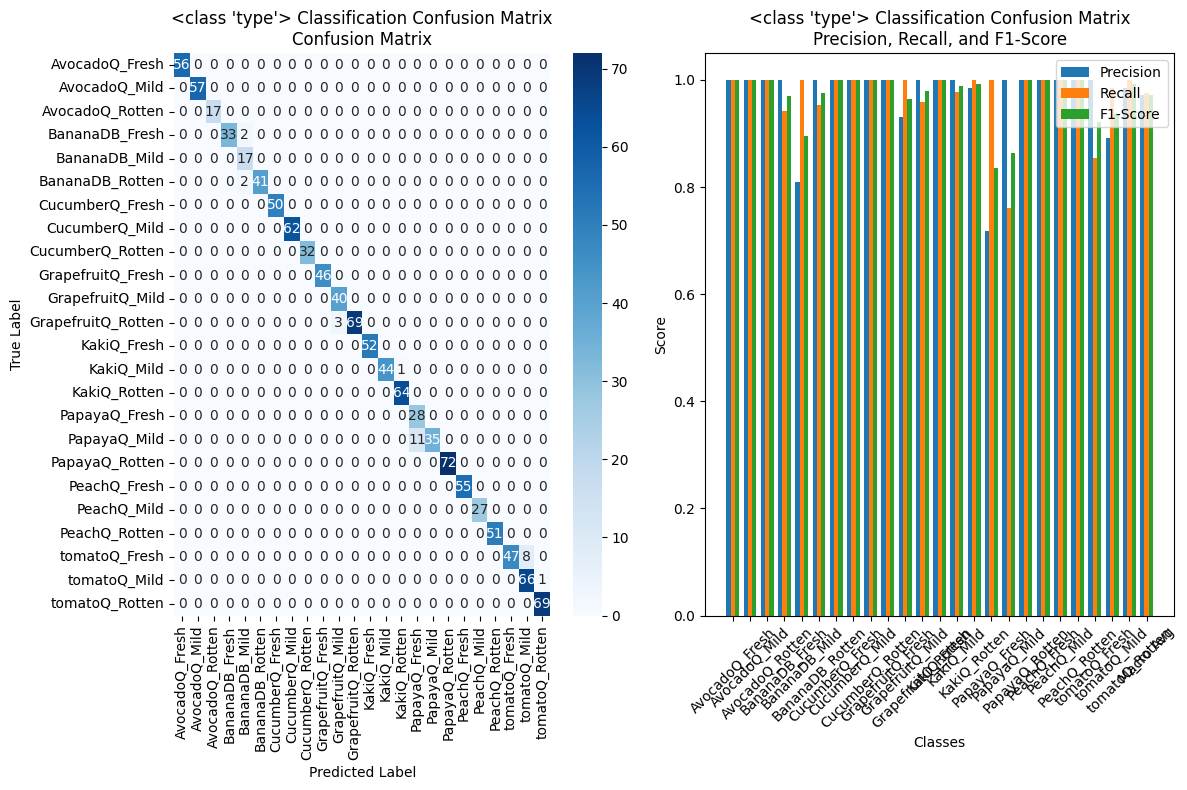


Detailed Classification Report:

Per-Class Metrics:
------------------------------------------------------------

AvocadoQ_Fresh:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000

AvocadoQ_Mild:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000

AvocadoQ_Rotten:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000

BananaDB_Fresh:
Precision: 1.000
Recall: 0.943
F1-Score: 0.971

BananaDB_Mild:
Precision: 0.810
Recall: 1.000
F1-Score: 0.895

BananaDB_Rotten:
Precision: 1.000
Recall: 0.953
F1-Score: 0.976

CucumberQ_Fresh:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000

CucumberQ_Mild:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000

CucumberQ_Rotten:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000

GrapefruitQ_Fresh:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000

GrapefruitQ_Mild:
Precision: 0.930
Recall: 1.000
F1-Score: 0.964

GrapefruitQ_Rotten:
Precision: 1.000
Recall: 0.958
F1-Score: 0.979

KakiQ_Fresh:
Precision: 1.000
Recall: 1.000
F1-Score: 1.000

KakiQ_Mild:
Precision: 1.000
Recall: 0.978
F

In [ ]:
evaluate_models(fruit_model, val_data)

In [ ]:
# clear session for next train

tf.keras.backend.clear_session(

    free_memory=True

)

# Evaluate the model using real data

In [ ]:


def load_and_preprocess_image(image_path, img_size=(224, 224)):

    """

    Load and preprocess an image for model prediction.

    """

    img = tf.keras.preprocessing.image.load_img(

        image_path,

        target_size=img_size

    )

    img_array = tf.keras.preprocessing.image.img_to_array(img)

    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)  # Use ResNet preprocessing

    return img_array



def predict_image(image_path, model, classes):

    """

    Predict the fruit type and its quality based on the given image.



    Args:

        image_path (str): Path to the input image.

        model (tf.keras.Model): Trained model for fruit classification.

        classes (list): List of fruit class names.

    Returns:

        dict: Prediction results including fruit type, quality, and confidence scores.

    """

    # Preprocess image

    img = load_and_preprocess_image(image_path)



    # Predict using the models

    pred = model.predict(img)



    # Get class predictions and confidence scores

    index = np.argmax(pred)



    return {

        'fruit': classes[index],

        'confidence': float(np.max(pred)),

    }


In [ ]:
prediction = predict_image(

    image_path='/content/drive/MyDrive/Kepston_bangkit/banana_agak_busuk.jpg',  # specify ur own path

    model=fruit_model,

    classes=class_names

)



print(prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
{'fruit': 'BananaDB_Rotten', 'confidence': 0.8021975755691528}


# Fine-Tune the saved model

In [ ]:
def fine_tune_model(model, base_model, fine_tune_at, learning_rate=1e-5):
    """
    Fine-tune the given model starting from `fine_tune_at` layer.

    Args:
        model (tf.keras.Model): The previously trained model.
        base_model (tf.keras.Model): The base model (e.g., ResNet50).
        fine_tune_at (int): Layer index from which to start unfreezing.
        learning_rate (float): Lower learning rate for fine-tuning.

    Returns:
        tf.keras.Model: Fine-tuned model.
    """
    len(base_model.layers)

    # Unfreeze the base model starting from `fine_tune_at`
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Recompile the model with a lower learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Define the base model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Load the pre-trained model (if saved earlier)
model_path = '/kaggle/input/fruit_classifier_final/tensorflow2/default/1/fruit_classifier_final.keras'
model = tf.keras.models.load_model(model_path)

# model.load_weights('path_to_saved_weights.h5')  # Optional

# Fine-tune the model
fine_tune_at_layer = 140  # Adjust as needed based on model's layer structure
fine_tuned_model = fine_tune_model(model, base_model, fine_tune_at=fine_tune_at_layer)


In [ ]:
# layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [ ]:
fine_tuned_model.summary()

Model: "fruit_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,853,080 (90.99 MB)

 Trainable params: 265,368 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
def finetune_callbacks():

    return [

        tf.keras.callbacks.EarlyStopping(

            monitor='val_loss',

            patience=3,

            restore_best_weights=True,

            min_delta=0.001

        ),

        tf.keras.callbacks.ModelCheckpoint(

            filepath=os.path.join(log_dir, 'model-{epoch:02d}-{val_accuracy:.2f}.keras'),

            monitor='val_accuracy',

            save_best_only=True,

            mode='max',

        ),

        tf.keras.callbacks.ReduceLROnPlateau(

            monitor='val_loss',

            factor=0.2,

            patience=4,

            min_lr=1e-6

        )

    ]




In [ ]:
fine_tune_history = fine_tuned_model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,  # fewer epochs for fine-tuning
    callbacks=finetune_callbacks(),
     class_weight=class_weight_dict
)


Epoch 1/15
580/580 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.9613 - loss: 0.1774 - val_accuracy: 0.9491 - val_loss: 0.1932 - learning_rate: 1.0000e-05
Epoch 2/15
580/580 ━━━━━━━━━━━━━━━━━━━━ 39s 67ms/step - accuracy: 0.9582 - loss: 0.1745 - val_accuracy: 0.9525 - val_loss: 0.1899 - learning_rate: 1.0000e-05
Epoch 3/15
580/580 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.9701 - loss: 0.1640 - val_accuracy: 0.9439 - val_loss: 0.1904 - learning_rate: 1.0000e-05
Epoch 4/15
580/580 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - accuracy: 0.9635 - loss: 0.1687 - val_accuracy: 0.9421 - val_loss: 0.1913 - learning_rate: 1.0000e-05
Epoch 5/15
580/580 ━━━━━━━━━━━━━━━━━━━━ 38s 66ms/step - accuracy: 0.9722 - loss: 0.1531 - val_accuracy: 0.9387 - val_loss: 0.1986 - learning_rate: 1.0000e-05


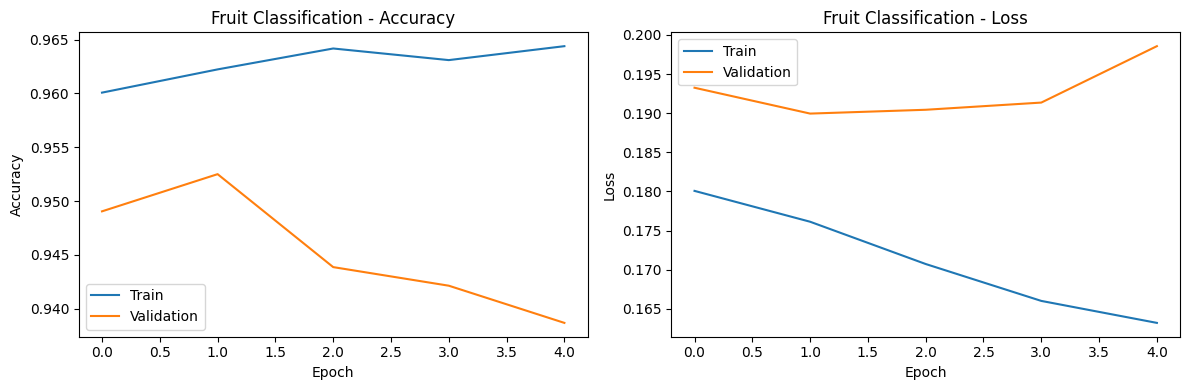

In [ ]:
plot_training_history(fine_tune_history, "Fruit Classification")

In [ ]:
fine_tuned_model.save('fruit_classifier_final_improved_fine_tuned.keras')